<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#ggraph" data-toc-modified-id="ggraph-5">ggraph</a></span></li><li><span><a href="#covid-acute-vs-healthy-(test)" data-toc-modified-id="covid-acute-vs-healthy-(test)-6">covid acute vs healthy (test)</a></span></li><li><span><a href="#CHOP-samples" data-toc-modified-id="CHOP-samples-7">CHOP samples</a></span></li></ul></div>

# Dependencies

In [1]:
pacman::p_load(igraph, graphlayouts, ggraph, ggforce, dplyr)

# Functions

In [2]:
#source("/Users/anabbi/git/ped_CapTCRseq/R/Immune_diversity.R")

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"

gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [4]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/"

# Main

In [5]:
load(file = paste0(datapath, "capTCRseq/gliph_int_covid_tcr.RData"))

In [6]:
gliphoutput <- read.csv(paste0(h4hpath,'/GLIPH/int_covid_tcr_cluster.csv'), header = T)

In [7]:
dim(gliphoutput)

[1] 301942     29

In [8]:
head(gliph_int_covid_tcr)

,CDR3b,TRBV,TRBJ,CDR3a,subject:condition,count,clonefraction,subject,file,index
,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,CAIRDPEQGITDTQYF,TRBV10-3,TRBJ2-3,NA,CHP_315:1,24,0.025369979,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,1
2,CAIRGTGADQPQHF,TRBV10-3,TRBJ1-5,NA,CHP_315:2,21,0.022198732,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,2
3,CAISGVWGGDTQYF,TRBV10-3,TRBJ2-3,NA,CHP_315:3,12,0.012684989,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,3
4,CASRLAGTGSPLHF,TRBV6-1,TRBJ1-6,NA,CHP_315:4,2,0.002114165,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,4
5,CASSDPQGTEAFF,TRBV6-2,TRBJ1-1,NA,CHP_315:5,21,0.022198732,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,5
6,CASSEEPGTSGYNEQFF,TRBV2,TRBJ2-1,NA,CHP_315:6,6,0.006342495,CHP_315-05-PBMC-DNA,/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,6


# ggraph

map back to the original data

In [9]:
gliph_all <- merge(gliph_int_covid_tcr, gliphoutput, 
                   by.x = "subject:condition", by.y = "Sample", all = T)

In [10]:
dim(gliphoutput)

[1] 301942     29

In [12]:
#remove HLA cols they are empty
HLAcol <- colnames(gliph_all)[!grepl("HLA", colnames(gliph_all))]
gliph_all <- gliph_all[, ..HLAcol]

In [13]:
colnames(gliph_all)

[1] "subject:condition"  "CDR3b"              "TRBV"              
 [4] "TRBJ"               "CDR3a"              "count"             
 [7] "clonefraction"      "subject"            "file"              
[10] "index.x"            "index.y"            "pattern"           
[13] "Fisher_score"       "number_subject"     "number_unique_cdr3"
[16] "final_score"        "hla_score"          "vb_score"          
[19] "expansion_score"    "length_score"       "cluster_size_score"
[22] "type"               "TcRb"               "V"                 
[25] "J"                  "TcRa"               "Freq"

# covid acute vs healthy (test)

In [195]:
gliph_covid <- gliph_all[grepl(paste(c("eJL158", "eXL36"), #1 COVID+, 1 Healthy
                                       collapse = "|"), gliph_all$`subject:condition`),]

In [196]:
#if pattern is NA = not clustered
gliph_covid$pattern[ is.na(gliph_covid$pattern)] <- "Not clustered"

In [197]:
# just to consider those cdr3s with the same sequence but different VJ
gliph_covid$CDR3_VJ <- paste(gliph_covid$CDR3b, gliph_covid$TRBV, gliph_covid$TRBJ, sep = "_")

In [198]:
#if subject contains more than one sample == public
gliph_covid$subject[ grepl(",", gliph_covid$subject)] <- "public"

In [199]:
#remove Not clustered to create an edge list
gliph_covid_clustered <- gliph_covid[ gliph_covid$pattern != "Not clustered",]

In [200]:
colnames(gliph_covid_clustered)

[1] "subject:condition"  "CDR3b"              "TRBV"              
 [4] "TRBJ"               "CDR3a"              "count"             
 [7] "clonefraction"      "subject"            "file"              
[10] "index.x"            "index.y"            "pattern"           
[13] "Fisher_score"       "number_subject"     "number_unique_cdr3"
[16] "final_score"        "hla_score"          "vb_score"          
[19] "expansion_score"    "length_score"       "cluster_size_score"
[22] "type"               "TcRb"               "V"                 
[25] "J"                  "TcRa"               "Freq"              
[28] "CDR3_VJ"

In [201]:
#from stackoverflow to find all combos for each pattern
edgedf <- gliph_covid_clustered %>% group_by(pattern) %>%
  filter(n()>=2) %>% do(data.frame(t(combn(.$CDR3_VJ, 2)), stringsAsFactors=FALSE)) %>% ungroup()

In [202]:
head(edgedf)

pattern,X1,X2
<chr>,<chr>,<chr>
%AANTGE,CAVGAANTGELFF_TRBV07-09_TRBJ02-02,CASGAANTGELFF_TRBV07-09_TRBJ02-02
%DANTGE,CANQDANTGELFF_TRBV06-06_TRBJ02-02,CASDDANTGELFF_TRBV07-08_TRBJ02-02
%DLNTGE,CATGDLNTGELFF_TRBV15-01_TRBJ02-02,CATQDLNTGELFF_TRBV06-X_TRBJ02-02
%DLNTGE,CATGDLNTGELFF_TRBV15-01_TRBJ02-02,CARADLNTGELFF_TRBV07-08_TRBJ02-02
%DLNTGE,CATQDLNTGELFF_TRBV06-X_TRBJ02-02,CARADLNTGELFF_TRBV07-08_TRBJ02-02
%DQNTGE,CAISDQNTGELFF_TRBV12-03/12-04_TRBJ02-02,CATQDQNTGELFF_TRBV06-04_TRBJ02-02


In [203]:
#create vertex list
vertexdf <- gliph_covid[,c("CDR3_VJ", "count", "subject")]
vertexdf <- vertexdf[!duplicated(vertexdf$CDR3_VJ),]

In [204]:
gliph_data_igrf <- graph_from_data_frame(d = edgedf[, c("X1", "X2", "pattern")], 
                                         vertices = vertexdf, directed = FALSE)

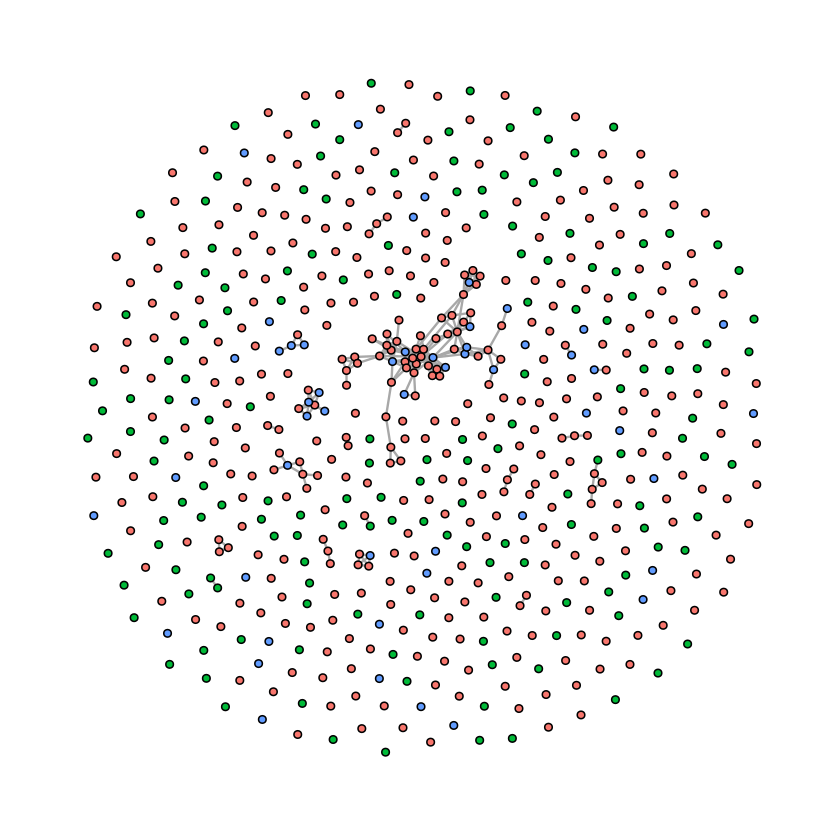

In [205]:
set.seed(1)
ggraph(gliph_data_igrf, layout = "graphopt") + #graphopt, fr, mds
  geom_edge_link0(edge_colour = "grey66") +
  geom_node_point(aes(fill = subject), shape = 21) +
#  geom_node_text(aes(filter = size >= 26, label = name), family = "serif") +
#  scale_fill_manual() +
#  scale_edge_width(range = c(0.2, 3)) +
#  scale_size(range = c(1, 6)) +
  theme_graph() +
  theme(legend.position = "none")

In [206]:
gliph_data_igrf1 <- delete.vertices(gliph_data_igrf, which(degree(gliph_data_igrf) == 0))

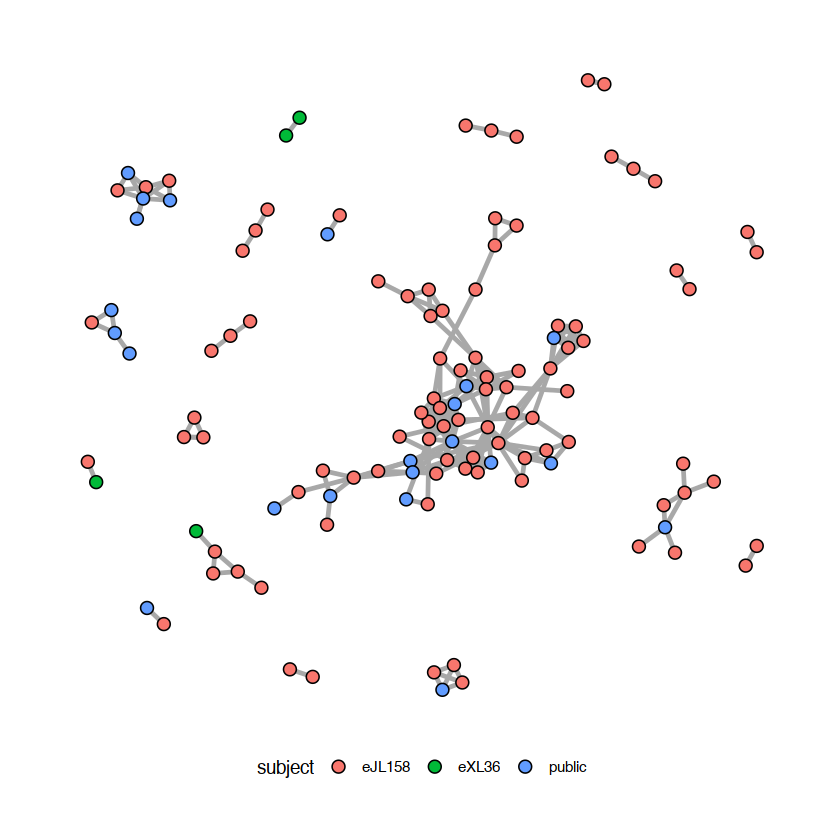

In [255]:
set.seed(1)
ggraph(gliph_data_igrf1, layout = "graphopt") + #graphopt, fr, mds
  geom_edge_link0(edge_colour = "grey66", width = 1) +
  geom_node_point(aes(fill = subject), shape = 21, size = 3) +
#  geom_node_text(aes(filter = size >= 26, label = name), family = "serif") +
#  scale_fill_manual() +
#  scale_edge_width(range = c(0.2, 3)) +
#  scale_size(range = c(1, 6)) +
  theme_graph(base_family="sans") +
  theme(legend.position = "bottom") 

# CHOP samples

In [71]:
gliph_chp <- gliph_all[grepl("CHP", gliph_all$`subject:condition`),]

In [72]:
#if pattern is NA = not clustered
gliph_chp$pattern[ is.na(gliph_chp$pattern)] <- "Not clustered"

In [73]:
# just to consider those cdr3s with the same sequence but different VJ
gliph_chp$CDR3_VJ <- paste(gliph_chp$CDR3b, gliph_chp$TRBV, gliph_chp$TRBJ, sep = "_")

In [74]:
#if subject contains more than one sample == public
gliph_chp$subject[ grepl(",", gliph_chp$subject)] <- "public"

In [103]:
#remove Not clustered to create an edge list
# filter
gliph_chp_clustered <- gliph_chp[ gliph_chp$pattern != "Not clustered",]
gliph_chp_clustered <- gliph_chp_clustered[ gliph_chp_clustered$pattern != "single",]
gliph_chp_clustered <- gliph_chp_clustered[ gliph_chp_clustered$number_subject >= 3,]
gliph_chp_clustered <- gliph_chp_clustered[ gliph_chp_clustered$number_unique_cdr3 >= 3,]

gliph_chp_clustered <- gliph_chp_clustered[ gliph_chp_clustered$Fisher_score < 1e-04,]

In [104]:
dim(gliph_chp_clustered)

[1] 1823   28

In [105]:
#from stackoverflow to find all combos for each pattern
edgedf <- gliph_chp_clustered %>% group_by(pattern) %>%
  filter(n()>=2) %>% do(data.frame(t(combn(.$CDR3_VJ, 2)), stringsAsFactors=FALSE)) %>% ungroup()

In [106]:
head(edgedf)

pattern,X1,X2
<chr>,<chr>,<chr>
%DGNTGE,CASGDGNTGELFF_TRBV7-9_TRBJ2-2,CASIDGNTGELFF_TRBV19_TRBJ2-2
%DGNTGE,CASGDGNTGELFF_TRBV7-9_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2
%DGNTGE,CASGDGNTGELFF_TRBV7-9_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2
%DGNTGE,CASIDGNTGELFF_TRBV19_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2
%DGNTGE,CASIDGNTGELFF_TRBV19_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2
%DGNTGE,CASSDGNTGELFF_TRBV6-4_TRBJ2-2,CASSDGNTGELFF_TRBV6-4_TRBJ2-2


In [107]:
#create vertex list
vertexdf <- gliph_chp_clustered[,c("CDR3_VJ", "count", "subject")]
vertexdf <- vertexdf[!duplicated(vertexdf$CDR3_VJ),]

In [108]:
gliph_data_igrf <- graph_from_data_frame(d = edgedf[, c("X1", "X2", "pattern")], vertices = vertexdf, directed = FALSE)

In [109]:
load(file = paste0(datapath,"capTCRseq/meta_div_TRB.RData"))

In [110]:
colnames(meta_div)

[1] "sample_id"          "Patient"            "cycle"             
 [4] "FOLD"               "ATC"                "Age"               
 [7] "Disease_type"       "TE_fold"            "Pass"              
[10] "CD3"                "EM"                 "CM"                
[13] "Naïve"              "SCM"                "TE"                
[16] "EM."                "CM."                "Naïve."            
[19] "SCM."               "TE."                "Naïve.TE"          
[22] "N.CM.SCM.TE.EM"     "PD.1"               "PDL1"              
[25] "LAG3"               "TIM3"               "CTLA4"             
[28] "PD1."               "PDL1."              "LAG3."             
[31] "TIM3."              "CTLA4."             "Any.NCR"           
[34] "PD1...LAG3...TIM3"  "cancergroup"        "TRB"               
[37] "Reads"              "CPKR"               "Average_reads"     
[40] "VMR"                "Max_reads"          "Singletons"        
[43] "Doubletons"         "qD"                 "Sample_Coverage"   
[46] "observed_Richness"  "estimated_Richness" "SE_Richeness"      
[49] "observed_Shannon"   "estimated_Shannon"  "SE_Shannon"        
[52] "observed_Simpson"   "estimated_Simpson"  "SE_Simpson"        
[55] "file"               "basename"           "Group"             
[58] "sampletype"

In [111]:
#just to simplify a little bit
gliph_data_igrf1 <- delete.vertices(gliph_data_igrf, which(degree(gliph_data_igrf) == 0))

In [112]:
V(gliph_data_igrf1)$cancer <- meta_div$cancergroup[ match(V(gliph_data_igrf1)$subject,
                                                          meta_div$basename)]

In [ ]:
chp_layout <- create_layout(gliph_data_igrf1, "drl")

In [ ]:
#pdf(paste0(plotpath, "chp_graph_mds.pdf"), width = 10, height = 10)
set.seed(1)
ggraph(chp_layout) + #graphopt, fr, mds
  geom_edge_link0(edge_colour = "grey66", width = 1) +
  geom_node_point(aes(fill = cancer, size = count), shape = 21) +
#  geom_node_text(aes(filter = size >= 26, label = name), family = "serif") +
#  scale_fill_manual() +
#  scale_edge_width(range = c(0.2, 3)) +
#  scale_size(range = c(1, 6)) +
  theme_graph(base_family="sans") +
  theme(legend.position = "bottom") 

#dev.off()

In [402]:
bb <- layout_as_backbone(gliph_data_igrf, keep = 0.1)
E(gliph_data_igrf)$col <- FALSE
E(gliph_data_igrf)$col[bb$backbone] <- TRUE

ERROR: Error in layout_as_backbone(gliph_data_igrf, keep = 0.1): backbone layout does not work with multiple edges.


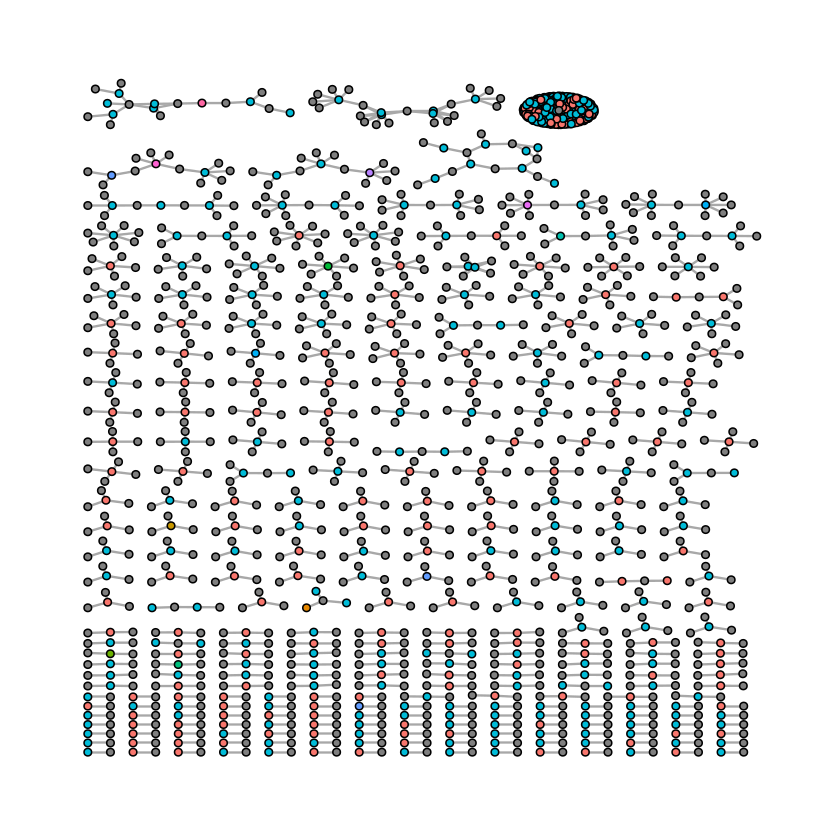

In [317]:
ggraph(gliph_data_igrf, layout = "manual", x = bb$xy[, 1], y = bb$xy[, 2]) +
  geom_edge_link0(edge_colour = "grey66") +
  geom_node_point(aes(fill = subject), shape = 21) +
#  geom_node_text(aes(filter = size >= 26, label = name), family = "serif") +
#  scale_fill_manual() +
#  scale_edge_width(range = c(0.2, 3)) +
#  scale_size(range = c(1, 6)) +
  theme_graph() +
  theme(legend.position = "none")

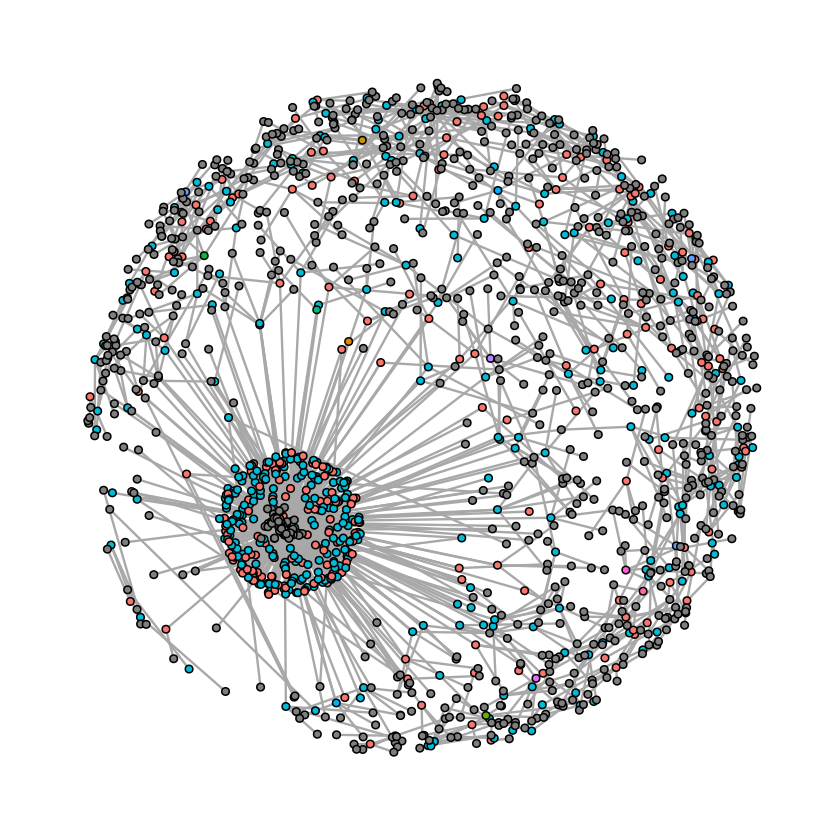

In [313]:
ggraph(gliph_data_igrf, layout = "kk") +
  geom_edge_link0(edge_colour = "grey66") +
  geom_node_point(aes(fill = subject), shape = 21) +
#  geom_node_text(aes(filter = size >= 26, label = name), family = "serif") +
#  scale_fill_manual() +
#  scale_edge_width(range = c(0.2, 3)) +
#  scale_size(range = c(1, 6)) +
  theme_graph() +
  theme(legend.position = "none")

In [178]:
head(gliph_covid[ gliph_covid$CDR3b == "CAIRQGASTEAFF",])

subject:condition,CDR3b,TRBV,TRBJ,CDR3a,count,clonefraction,subject,file,index.x,⋯,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Freq
<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.180,0.043,0.001,0.0062,global-%QGASTE,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.074,0.260,0.001,0.0290,global-R%GASTE,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.065,0.390,0.001,0.0290,global-RQG%STE,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.068,1.000,0.001,0.0290,global-RQGAS%E,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.072,0.420,0.001,0.0290,global-RQGA%TE,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1


In [174]:
head(hm)

CAIRQGASTEAFF  CAISPETQETQYF CAISTGSGNTEAFF    CARGTGLEQYF CARRGHPSNQPQHF 
       "eDH96"       "eHO133"       "eHO133"        "eDH96"       "eHO133" 
 CASADRDSYEQYF 
      "eHO133"

In [172]:
head(V(gliph_data_igrf)$name)

[1] "CAIRQGASTEAFF"  "CAISPETQETQYF"  "CAISTGSGNTEAFF" "CARGTGLEQYF"   
[5] "CARRGHPSNQPQHF" "CASADRDSYEQYF"

In [ ]:

for (i in c(1:length(V(gliph_data_igrf)$CloneCount))) {
    if (any(gliph_covid$Freq [gliph_covid$TcRb == V(gliph_data_igrf)$name[i]])) {
        V(gliph_data_igrf)$CloneCount[i] <- gliph_covid$Freq [gliph_covid$TcRb == V(gliph_data_igrf)$name[i]]
    }
}

In [170]:
gliph_covid[gliph_covid$TcRb == V(gliph_data_igrf)$name[1],]

subject:condition,CDR3b,TRBV,TRBJ,CDR3a,count,clonefraction,subject,file,index.x,⋯,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Freq
<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.180,0.043,0.001,0.0062,global-%QGASTE,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.074,0.260,0.001,0.0290,global-R%GASTE,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.065,0.390,0.001,0.0290,global-RQG%STE,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.068,1.000,0.001,0.0290,global-RQGAS%E,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1
eDH96:960,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1,1,eDH96,COVID_specific_TCRB.tsv,960,⋯,0.072,0.420,0.001,0.0290,global-RQGA%TE,CAIRQGASTEAFF,TRBV10-03,TRBJ01-01,NA,1


In [171]:
head(gliph_covid[ grepl(",", gliph_covid$subject),])

subject:condition,CDR3b,TRBV,TRBJ,CDR3a,count,clonefraction,subject,file,index.x,⋯,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Freq
<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
eDH96:113050,CASSWGREQYF,TRBV19-01,TRBJ02-07,NA,2,1,"eDH96, eXL36",COVID_specific_TCRB.tsv,113050,⋯,0.610,0.76,0.001,9.5e-05,global-SWG%E,CASSWGREQYF,TRBV19-01,TRBJ02-07,NA,2
eDH96:113050,CASSWGREQYF,TRBV19-01,TRBJ02-07,NA,2,1,"eDH96, eXL36",COVID_specific_TCRB.tsv,113050,⋯,0.970,0.17,0.001,8.6e-05,global-S%GRE,CASSWGREQYF,TRBV19-01,TRBJ02-07,NA,2
eDH96:113050,CASSWGREQYF,TRBV19-01,TRBJ02-07,NA,2,1,"eDH96, eXL36",COVID_specific_TCRB.tsv,113050,⋯,0.071,0.54,0.001,2.9e-02,global-%WGRE,CASSWGREQYF,TRBV19-01,TRBJ02-07,NA,2
eDH96:47097,CASSLEGQASSYEQYF,TRBV05-01,TRBJ02-07,NA,3,1,"eDH96, eEE243, ePD86",COVID_specific_TCRB.tsv,47097,⋯,0.069,0.50,0.001,9.5e-01,global-SLEGQASSYE,CASSLEGQASSYEQYF,TRBV05-01,TRBJ02-07,NA,3
eDH96:50707,CASSLGGYEQFF,TRBV12-03/12-04,TRBJ02-01,NA,2,1,"eDH96, eOX49",COVID_specific_TCRB.tsv,50707,⋯,0.950,0.99,0.001,1.7e-05,global-SLGG%E,CASSLGGYEQFF,TRBV12-03/12-04,TRBJ02-01,NA,2
eDH96:50707,CASSLGGYEQFF,TRBV12-03/12-04,TRBJ02-01,NA,2,1,"eDH96, eOX49",COVID_specific_TCRB.tsv,50707,⋯,1.000,0.99,0.001,2.9e-05,global-S%GGYE,CASSLGGYEQFF,TRBV12-03/12-04,TRBJ02-01,NA,2


In [167]:
V(gliph_data_igrf)$name[1]

[1] "CAIRQGASTEAFF"

In [166]:
any(gliph_covid$Freq[gliph_covid$TcRb == V(gliph_data_igrf)$name[1]])

Warning message in any(gliph_covid$Freq[gliph_covid$TcRb == V(gliph_data_igrf)$name[1]]):
“coercing argument of type 'double' to logical”


[1] TRUE

In [20]:
library(networkdata)

In [22]:
data("got")

gotS1 <- got[[1]]


In [46]:
summary(gotS1)

IGRAPH 1acc9b3 UNW- 127 550 -- GoT (Season 1)
+ attr: name (g/c), name (v/c), clu (v/c), size (v/n), weight (e/n)


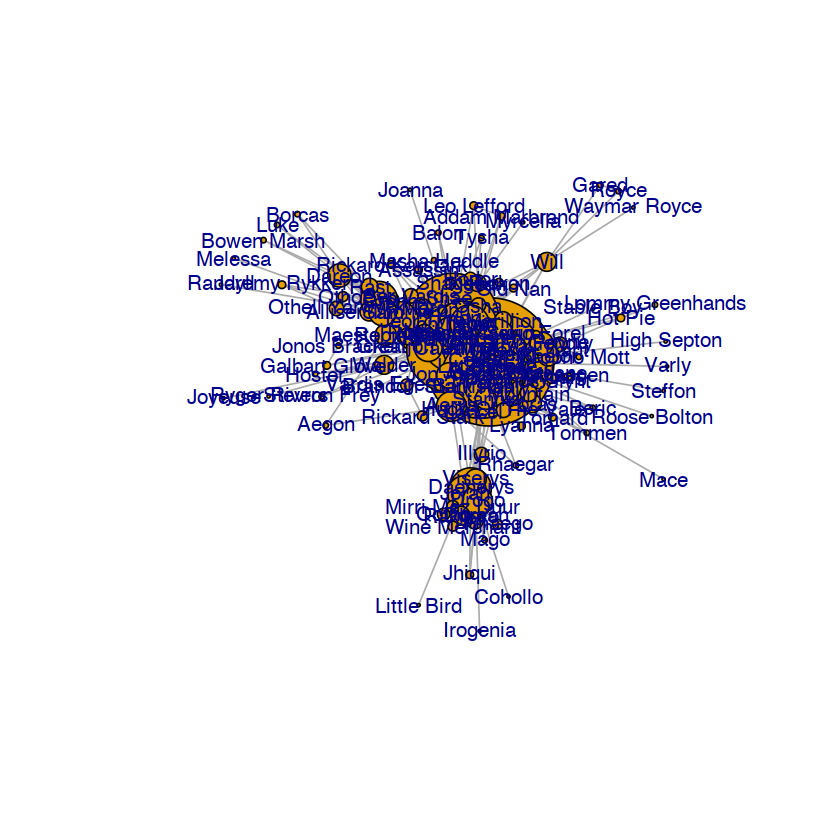

In [47]:
plot(gotS1)

In [48]:
got_palette <- c(
  "#1A5878", "#C44237", "#AD8941", "#E99093",
  "#50594B", "#8968CD", "#9ACD32"
)

# compute a clustering for node colors
V(gotS1)$clu <- as.character(membership(cluster_louvain(gotS1)))

# compute degree as node size
V(gotS1)$size <- degree(gotS1)

In [56]:
V(gotS1)$clu
V(gotS1)$size

[1] "1" "2" "3" "1" "1" "4" "5" "1" "5" "1" "1" "5" "3" "4" "4" "1" "1" "1"
 [19] "2" "4" "3" "3" "4" "5" "2" "5" "3" "1" "2" "1" "2" "4" "5" "3" "1" "4"
 [37] "4" "1" "1" "2" "1" "5" "1" "1" "6" "1" "2" "1" "1" "5" "4" "1" "1" "3"
 [55] "5" "1" "3" "3" "3" "7" "4" "1" "5" "1" "1" "1" "1" "4" "7" "4" "4" "7"
 [73] "5" "4" "4" "1" "4" "2" "4" "4" "5" "2" "2" "4" "1" "3" "3" "3" "4" "1"
 [91] "3" "5" "4" "5" "3" "3" "3" "3" "1" "2" "4" "1" "3" "2" "1" "5" "1" "4"
[109] "1" "2" "6" "4" "2" "1" "1" "1" "1" "7" "2" "2" "5" "1" "2" "1" "1" "1"
[127] "1"

[1] 57 18 26 26 28 37 12 29  3 27 26 41 16 30 20 24  8  8 15  9  8  9 12  7  8
 [26]  7 16 17 13 11  6  6  4  8 18 19 10 36  5  5 16  7  5  6  3 11  7  9  3  7
 [51] 13 13  9 10  6  6  9  6  7  2  2  7  2  7 10  3  4  3  2  1  2  1  3  3  2
 [76]  2  5  1  5  2  1  5  8  3 21  2  2  2  3  1  3  1  1  3  2  1  4  1  2  4
[101]  3  9 12  9  6 17  3  8 16  4  2  1  2  2  1  3  4  8  3  1  2  2  1  1  1
[126]  1  1

In [53]:
V(gotS1)$clu

[1] "1" "2" "3" "1" "1" "4" "5" "1" "5" "1" "1" "5" "3" "4" "4" "1" "1" "1"
 [19] "2" "4" "3" "3" "4" "5" "2" "5" "3" "1" "2" "1" "2" "4" "5" "3" "1" "4"
 [37] "4" "1" "1" "2" "1" "5" "1" "1" "6" "1" "2" "1" "1" "5" "4" "1" "1" "3"
 [55] "5" "1" "3" "3" "3" "7" "4" "1" "5" "1" "1" "1" "1" "4" "7" "4" "4" "7"
 [73] "5" "4" "4" "1" "4" "2" "4" "4" "5" "2" "2" "4" "1" "3" "3" "3" "4" "1"
 [91] "3" "5" "4" "5" "3" "3" "3" "3" "1" "2" "4" "1" "3" "2" "1" "5" "1" "4"
[109] "1" "2" "6" "4" "2" "1" "1" "1" "1" "7" "2" "2" "5" "1" "2" "1" "1" "1"
[127] "1"